In [26]:
import os
import tensorflow as tf
from tensorflow.keras.layers import Resizing, Rescaling, Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras import Sequential
from tensorflow.image import random_flip_up_down, random_flip_left_right, random_contrast, random_brightness
from PIL import Image
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import random

In [2]:
initial_max_height, initial_max_width = 0, 0
initial_min_height, initial_min_width = 100000, 100000

cancer_types = ['pituitary','notumor','glioma','meningioma']
dataset_types = ['Training','Testing']
data = {
        'Training':{'file_loc':[], 'label':[], 'input_data':[]},
        'Testing':{'file_loc':[], 'label':[], 'input_data':[]}
        }
# Dataset sizes, and create dictionary with labels
print('Total images available...')
for dataset in dataset_types:
    for cancer in cancer_types:
        for loc in os.listdir(os.path.join('data',dataset,cancer)):
            #print(os.path.join('data',dataset,cancer,loc))
            if dataset == "Training":
                data["Training"]["file_loc"].append(os.path.join('data',dataset,cancer,loc))
                data["Training"]["label"].append(cancer)
                image = tf.io.read_file(os.path.join('data',dataset,cancer,loc))
                image_tensor = tf.image.decode_jpeg(image, channels = 1)           
                data["Training"]["input_data"].append(tf.reshape(image_tensor, shape = (image_tensor.shape[0], image_tensor.shape[1], 1)))
            else:
                data["Testing"]["file_loc"].append(os.path.join('data',dataset,cancer,loc))
                data["Testing"]["label"].append(cancer)
                image = tf.io.read_file(os.path.join('data',dataset,cancer,loc))
                image_tensor = tf.image.decode_jpeg(image, channels = 1)
                data["Testing"]["input_data"].append(tf.reshape(image_tensor, shape = (image_tensor.shape[0], image_tensor.shape[1], 1)))

        print(f'{cancer.capitalize()} {dataset.lower()}: {len(os.listdir(os.path.join('data',dataset,cancer)))}')





Total images available...
Pituitary training: 1457
Notumor training: 1595
Glioma training: 1321
Meningioma training: 1339
Pituitary testing: 300
Notumor testing: 405
Glioma testing: 300
Meningioma testing: 306


In [38]:
# (height, width, channels = 1)
#print(image_tensor.shape)

#Image.open('data/Training/notumor/Tr-no_0021.jpg')
#Image.open(data['Training']['file_loc'][1596])
data['Training']['input_data'][0]


<tf.Tensor: shape=(512, 512), dtype=uint8, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)>

In [5]:
# Min and max pixels: will need to crop/pad
height_data = [dat.shape[0] for dat in data["Training"]["input_data"]]
width_data = [dat.shape[1] for dat in data["Training"]["input_data"]]

print(f'Min picture height (pixels): {min(height_data)}')
print(f'Max picture height (pixels): {max(height_data)}')

print(f'Min picture width (pixels): {min(width_data)}')
print(f'Max picture width (pixels): {max(width_data)}')

Min picture height (pixels): 168
Max picture height (pixels): 1446
Min picture width (pixels): 150
Max picture width (pixels): 1920


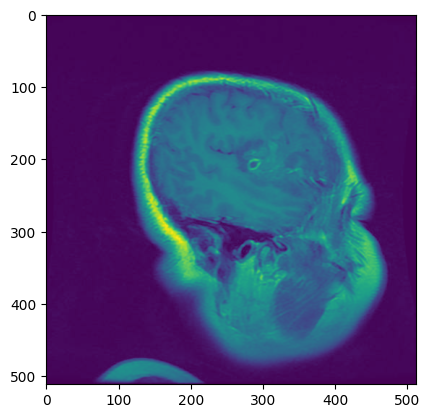

In [ ]:
"""
Data augmentation steps to explore... 
- horizontal/vertical flips (random_flip_left_right/random_flip_up_down)
- adjust brightness 
- adjust contrast
- combination of multiple...

"""

plt.imshow(tf.image.resize(images = data['Training']['input_data'][4000], size = [512,512], method = 'bilinear').numpy());

In [ ]:
# Nominally encode labels
le = LabelEncoder()
y_train = le.fit_transform(data['Training']['label'])
y_test = le.transform(data['Testing']['label'])

4

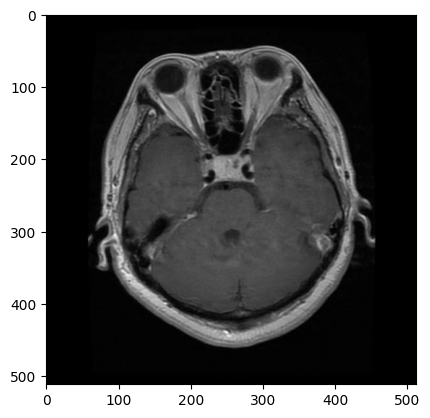

In [60]:
# Functions for each potential image augmentation to conduct on training data
def vertical_flip(image: tf.Tensor):
    return random_flip_up_down(image)

def horizontal_flip(image: tf.Tensor):
    return random_flip_left_right(image)

def adjust_brightness(image: tf.Tensor):
    return random_brightness(image, 0.5)

def adjust_contrast(image: tf.Tensor):
    return random_contrast(image, 0.2, 0.7)

def create_augmented_image(image: tf.Tensor):
    aug_functions = [vertical_flip, horizontal_flip, adjust_brightness, adjust_contrast]
    augmentations = random.choices(aug_functions, k = random.randint(1,4))
    for aug in augmentations:
        image = aug(image)
    return image


plt.imshow(data["Training"]["input_data"][0], cmap='grey');


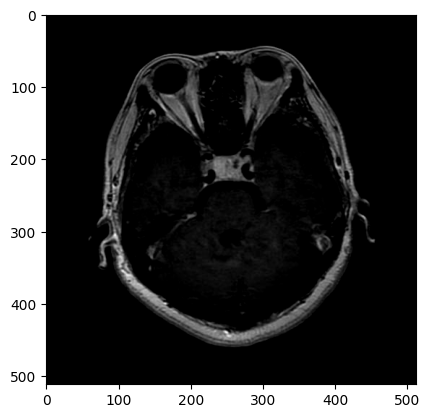

In [69]:
plt.imshow(create_augmented_image(data["Training"]["input_data"][0]), cmap='grey');





In [ ]:
# Define model layers
output_units = len(le.classes_)

model = Sequential([
    Resizing(height = 800, width = 800, crop_to_aspect_ratio=True, pad_to_aspect_ratio=True)
    Rescaling(scale = 1./255),
    Conv2D(32, (4,4), activation = 'relu', input_shape = (750, 750, 1)),
    MaxPooling2D((2,2), padding = 1),
    Conv2D(64, (4,4), activation = 'relu'),
    MaxPooling2D((2,2)),
    Conv2D(128, (4,4), activation = 'relu'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(128, activation = 'relu'),
    Dense(output_units, acitvation = 'softmax')  
])